In [3]:
import pandas as pd
import spacy
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [16]:
# Step 1: Load the data
gossipcop_fake = pd.read_csv('gossipcop_fake.csv')
gossipcop_real = pd.read_csv('gossipcop_real.csv')
politifact_fake = pd.read_csv('politifact_fake.csv')
politifact_real = pd.read_csv('politifact_real.csv')

In [17]:
# Step 2: Data Exploration
print("GossipCop Fake Head:")
print(gossipcop_fake.head())

print("GossipCop Real Head:")
print(gossipcop_real.head())

print("PolitiFact Fake Head:")
print(politifact_fake.head())

print("PolitiFact Real Head:")
print(politifact_real.head())

GossipCop Fake Head:
                     id                                           news_url  \
0  gossipcop-2493749932  www.dailymail.co.uk/tvshowbiz/article-5874213/...   
1  gossipcop-4580247171  hollywoodlife.com/2018/05/05/paris-jackson-car...   
2   gossipcop-941805037  variety.com/2017/biz/news/tax-march-donald-tru...   
3  gossipcop-2547891536  www.dailymail.co.uk/femail/article-3499192/Do-...   
4  gossipcop-5476631226  variety.com/2018/film/news/list-2018-oscar-nom...   

                                               title  \
0  Did Miley Cyrus and Liam Hemsworth secretly ge...   
1  Paris Jackson & Cara Delevingne Enjoy Night Ou...   
2  Celebrities Join Tax March in Protest of Donal...   
3  Cindy Crawford's daughter Kaia Gerber wears a ...   
4      Full List of 2018 Oscar Nominations – Variety   

                                           tweet_ids  
0  284329075902926848\t284332744559968256\t284335...  
1  992895508267130880\t992897935418503169\t992899...  
2  85335

In [18]:
# Check columns across datasets
gossipcop_fake.info()
gossipcop_real.info()
politifact_fake.info()
politifact_real.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5323 entries, 0 to 5322
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         5323 non-null   object
 1   news_url   5067 non-null   object
 2   title      5323 non-null   object
 3   tweet_ids  5135 non-null   object
dtypes: object(4)
memory usage: 166.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16817 entries, 0 to 16816
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         16817 non-null  object
 1   news_url   16804 non-null  object
 2   title      16817 non-null  object
 3   tweet_ids  15759 non-null  object
dtypes: object(4)
memory usage: 525.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 432 entries, 0 to 431
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         432 non-null    object
 1   news_url

In [19]:
# Step 3: Prepare a combined dataset
def preprocess_data(fake_df, real_df, label):
    fake_df['label'] = 'fake'
    real_df['label'] = 'real'
    combined_df = pd.concat([fake_df, real_df], ignore_index=True)
    combined_df['source'] = label
    return combined_df


In [20]:
gossipcop_data = preprocess_data(gossipcop_fake, gossipcop_real, 'gossipcop')
politifact_data = preprocess_data(politifact_fake, politifact_real, 'politifact')

In [21]:
# Combine all data
combined_data = pd.concat([gossipcop_data, politifact_data], ignore_index=True)

In [22]:
# Step 4: NER Analysis using spaCy
nlp = spacy.load("en_core_web_sm")

def extract_entities(text):
    doc = nlp(text)
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    return entities

# Apply NER on the titles
combined_data['entities'] = combined_data['title'].astype(str).apply(extract_entities)

In [23]:
# Step 5: Popularity Analysis
def compute_popularity(tweet_ids):
    try:
        return len(tweet_ids.split(',')) if isinstance(tweet_ids, str) else 0
    except:
        return 0

combined_data['popularity'] = combined_data['tweet_ids'].apply(compute_popularity)

Correlation between popularity and news authenticity:
               popularity  label_encoded
popularity       1.000000      -0.058588
label_encoded   -0.058588       1.000000


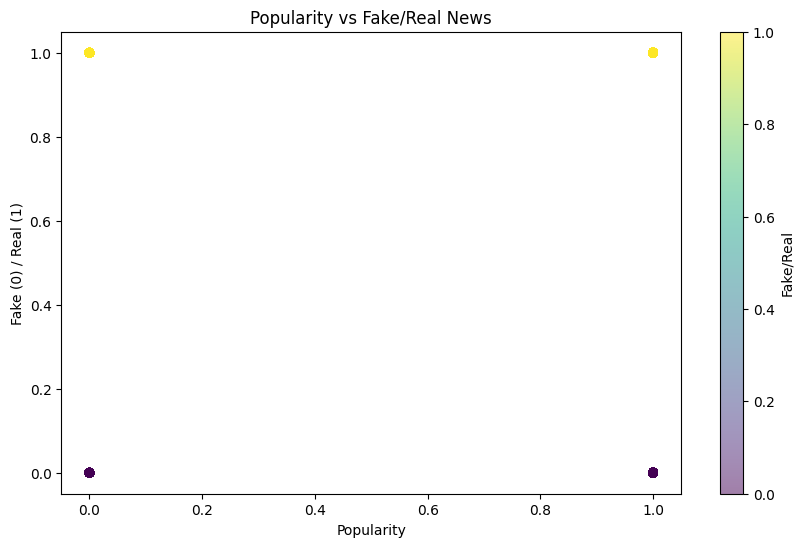

In [24]:
# Step 6: Correlation Study
le = LabelEncoder()
combined_data['label_encoded'] = le.fit_transform(combined_data['label'])
correlation = combined_data[['popularity', 'label_encoded']].corr()

print("Correlation between popularity and news authenticity:")
print(correlation)

# Visualization
plt.figure(figsize=(10, 6))
plt.scatter(combined_data['popularity'], combined_data['label_encoded'], alpha=0.5, c=combined_data['label_encoded'])
plt.title('Popularity vs Fake/Real News')
plt.xlabel('Popularity')
plt.ylabel('Fake (0) / Real (1)')
plt.colorbar(label='Fake/Real')
plt.show()


In [25]:
import pandas as pd
import spacy
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

# Function to load and preprocess datasets
def load_datasets():
    # Load all datasets
    gossipcop_fake = pd.read_csv('gossipcop_fake.csv')
    gossipcop_real = pd.read_csv('gossipcop_real.csv')
    politifact_fake = pd.read_csv('politifact_fake.csv')
    politifact_real = pd.read_csv('politifact_real.csv')

    # Add source and label columns
    gossipcop_fake['source'] = 'gossipcop'
    gossipcop_fake['label'] = 'fake'
    gossipcop_real['source'] = 'gossipcop'
    gossipcop_real['label'] = 'real'
    politifact_fake['source'] = 'politifact'
    politifact_fake['label'] = 'fake'
    politifact_real['source'] = 'politifact'
    politifact_real['label'] = 'real'

    # Combine all datasets
    combined_df = pd.concat([
        gossipcop_fake, gossipcop_real,
        politifact_fake, politifact_real
    ], ignore_index=True)

    return combined_df

# Function to calculate popularity score based on tweet_ids
def calculate_popularity(tweet_ids):
    if isinstance(tweet_ids, str):
        # Count number of tweet IDs
        return len(tweet_ids.split(','))
    return 0

# Function to extract named entities
def extract_entities(title, nlp):
    doc = nlp(title)
    entities = []
    for ent in doc.ents:
        entities.append((ent.text, ent.label_))
    return entities

# Main analysis function
def analyze_news_popularity():
    # Load spaCy model
    nlp = spacy.load('en_core_web_sm')

    # Load datasets
    print("Loading datasets...")
    df = load_datasets()

    # Calculate popularity scores
    print("Calculating popularity scores...")
    df['popularity_score'] = df['tweet_ids'].apply(calculate_popularity)

    # Extract named entities from titles
    print("Extracting named entities...")
    df['entities'] = df['title'].apply(lambda x: extract_entities(str(x), nlp))

    # Analyze entity distribution
    all_entities = []
    for ent_list in df['entities']:
        all_entities.extend([ent[0] for ent in ent_list])

    entity_counts = Counter(all_entities)
    top_entities = pd.DataFrame(entity_counts.most_common(20),
                              columns=['Entity', 'Count'])

    # Calculate correlation between popularity and fake/real news
    df['is_fake'] = df['label'].map({'fake': 1, 'real': 0})
    correlation = df['popularity_score'].corr(df['is_fake'])

    # Create visualizations
    plt.figure(figsize=(15, 10))

    # Plot 1: Distribution of popularity scores by news type
    plt.subplot(2, 1, 1)
    sns.boxplot(x='label', y='popularity_score', data=df)
    plt.title('Distribution of Popularity Scores by News Type')

    # Plot 2: Top entities bar plot
    plt.subplot(2, 1, 2)
    sns.barplot(data=top_entities.head(10), x='Count', y='Entity')
    plt.title('Top 10 Named Entities in News Titles')

    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print("\nSummary Statistics:")
    print(f"Total number of articles: {len(df)}")
    print(f"Average popularity score for real news: {df[df['label']=='real']['popularity_score'].mean():.2f}")
    print(f"Average popularity score for fake news: {df[df['label']=='fake']['popularity_score'].mean():.2f}")
    print(f"Correlation between popularity and fake news: {correlation:.3f}")

    return df, top_entities

def analyze_fake_news_patterns(df):
    # Group by source and label
    source_label_stats = df.groupby(['source', 'label']).agg({
        'popularity_score': ['mean', 'count'],
        'id': 'count'
    }).round(2)

    # Create popularity categories based on the actual distribution
    # First, get the unique values and their counts
    value_counts = df['popularity_score'].value_counts().sort_index()
    print("\nDistribution of popularity scores:")
    print(value_counts)

    # Create categories based on the actual distribution
    if len(value_counts) <= 5:
        # If we have 5 or fewer unique values, use them directly
        df['popularity_category'] = df['popularity_score'].astype(str)
    else:
        # If we have more than 5 values, create reasonable bins
        median_score = df['popularity_score'].median()
        mean_score = df['popularity_score'].mean()

        def categorize_popularity(score):
            if score == 0:
                return 'No Engagement'
            elif score < median_score:
                return 'Low Engagement'
            elif score < mean_score:
                return 'Medium Engagement'
            else:
                return 'High Engagement'

        df['popularity_category'] = df['popularity_score'].apply(categorize_popularity)

    # Create the cross-tabulation
    popularity_vs_fake = pd.crosstab(
        df['popularity_category'],
        df['label'],
        normalize='index'
    ) * 100

    # Visualize results
    plt.figure(figsize=(12, 6))

    # Create bar plot
    ax = popularity_vs_fake.plot(kind='bar', stacked=True)
    plt.title('Distribution of Real vs Fake News by Engagement Level')
    plt.xlabel('Engagement Level')
    plt.ylabel('Percentage')
    plt.legend(title='News Type')
    plt.xticks(rotation=45)

    # Add value labels on the bars
    for c in ax.containers:
        ax.bar_label(c, fmt='%.1f%%')

    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print("\nPopularity Statistics by Source and Label:")
    print(source_label_stats)

    print("\nDistribution of Real vs Fake News by Engagement Level:")
    print(popularity_vs_fake.round(2))

    # Additional analysis
    print("\nEngagement Summary Statistics:")
    print(f"Mean engagement score: {df['popularity_score'].mean():.2f}")
    print(f"Median engagement score: {df['popularity_score'].median():.2f}")
    print(f"Max engagement score: {df['popularity_score'].max():.2f}")

    # Compare engagement between real and fake news
    print("\nMean Engagement by News Type:")
    print(df.groupby('label')['popularity_score'].mean())

    return source_label_stats, popularity_vs_fake


# For use in Google Colab, add this cell to install required packages:
"""
!pip install spacy
!python -m spacy download en_core_web_sm
"""

'\n!pip install spacy\n!python -m spacy download en_core_web_sm\n'

Loading datasets...
Calculating popularity scores...
Extracting named entities...


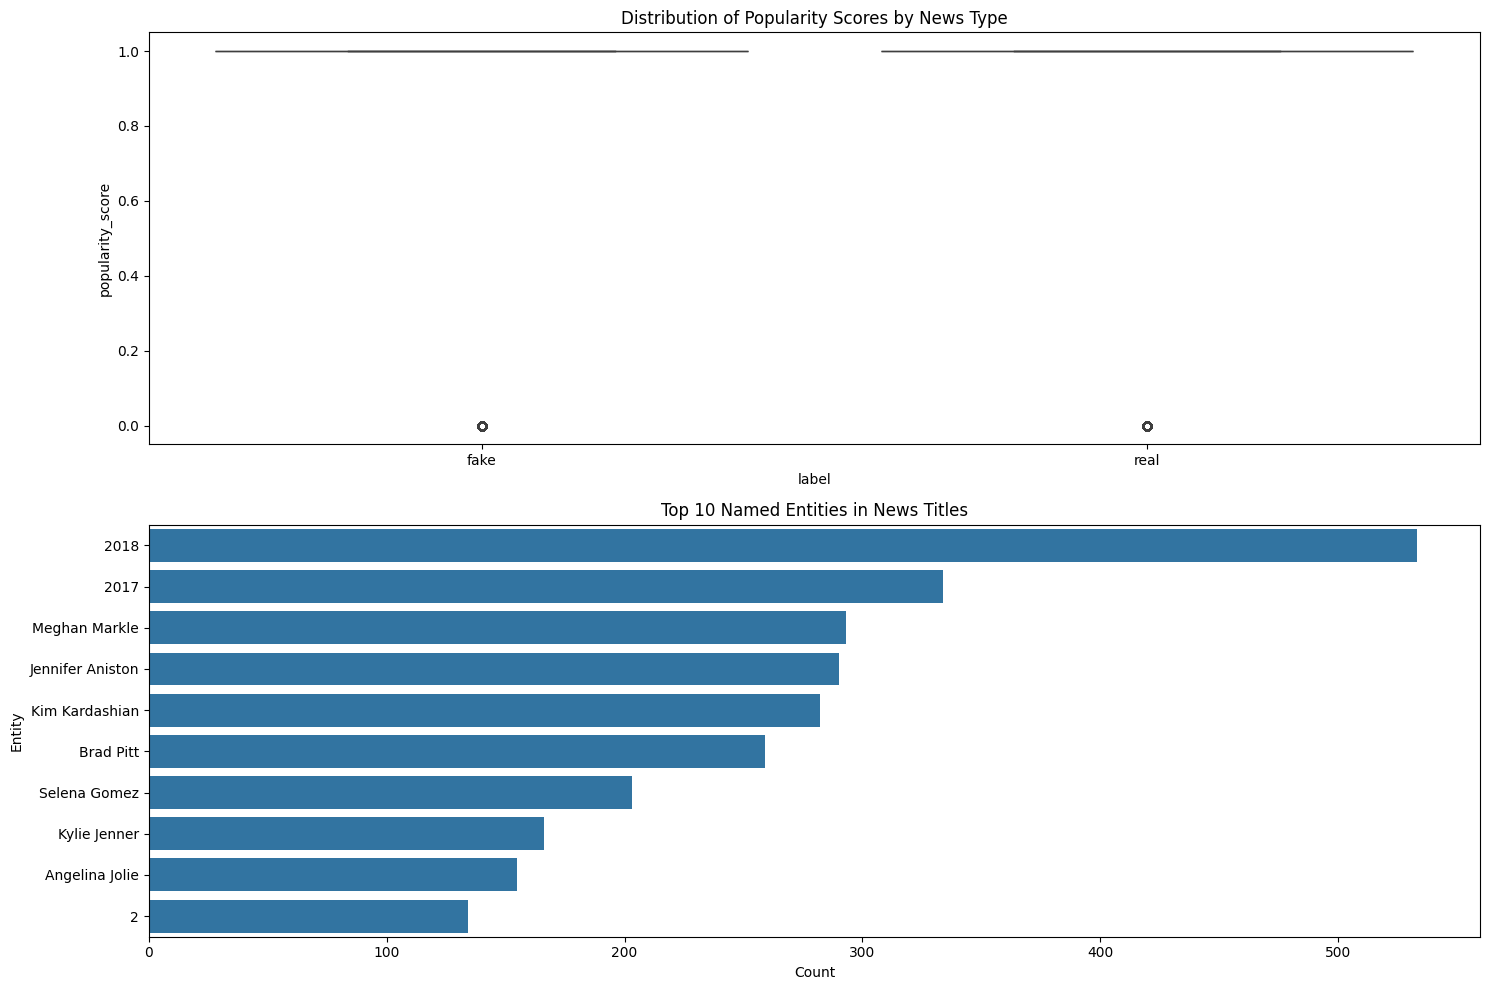


Summary Statistics:
Total number of articles: 23196
Average popularity score for real news: 0.93
Average popularity score for fake news: 0.96
Correlation between popularity and fake news: 0.059


In [26]:
# Run the main analysis
df, top_entities = analyze_news_popularity()



Distribution of popularity scores:
popularity_score
0     1501
1    21695
Name: count, dtype: int64


<Figure size 1200x600 with 0 Axes>

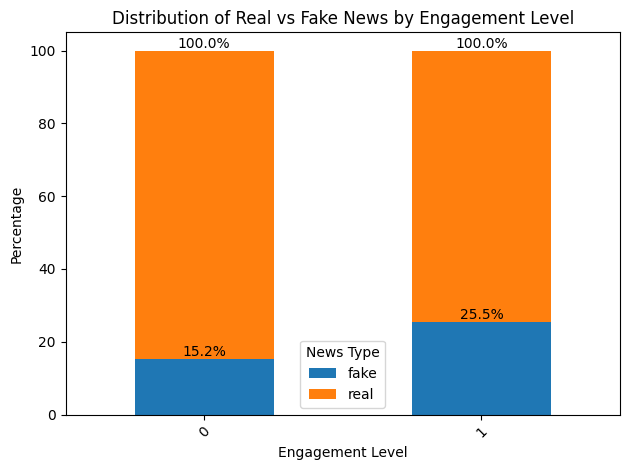


Popularity Statistics by Source and Label:
                 popularity_score            id
                             mean  count  count
source     label                               
gossipcop  fake              0.96   5323   5323
           real              0.94  16817  16817
politifact fake              0.91    432    432
           real              0.66    624    624

Distribution of Real vs Fake News by Engagement Level:
label                 fake   real
popularity_category              
0                    15.19  84.81
1                    25.48  74.52

Engagement Summary Statistics:
Mean engagement score: 0.94
Median engagement score: 1.00
Max engagement score: 1.00

Mean Engagement by News Type:
label
fake    0.960382
real    0.927011
Name: popularity_score, dtype: float64


In [27]:
# Now run the fixed detailed analysis
source_stats, popularity_fake_dist = analyze_fake_news_patterns(df)

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
